### Hilbert DDPM for 1D toy example

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from util import gp_sampler,np2torch,kernel_se,get_rkhs_proj
from ddpm import get_ddpm_constants,plot_ddpm_constants,get_ddpm_loss,eval_hddpm_1D
from model import DenoisingDenseUNetClass
np.set_printoptions(precision=2)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rc('xtick',labelsize=5); plt.rc('ytick',labelsize=5)
print ("Ready.")

Ready.


### Diffusion constants

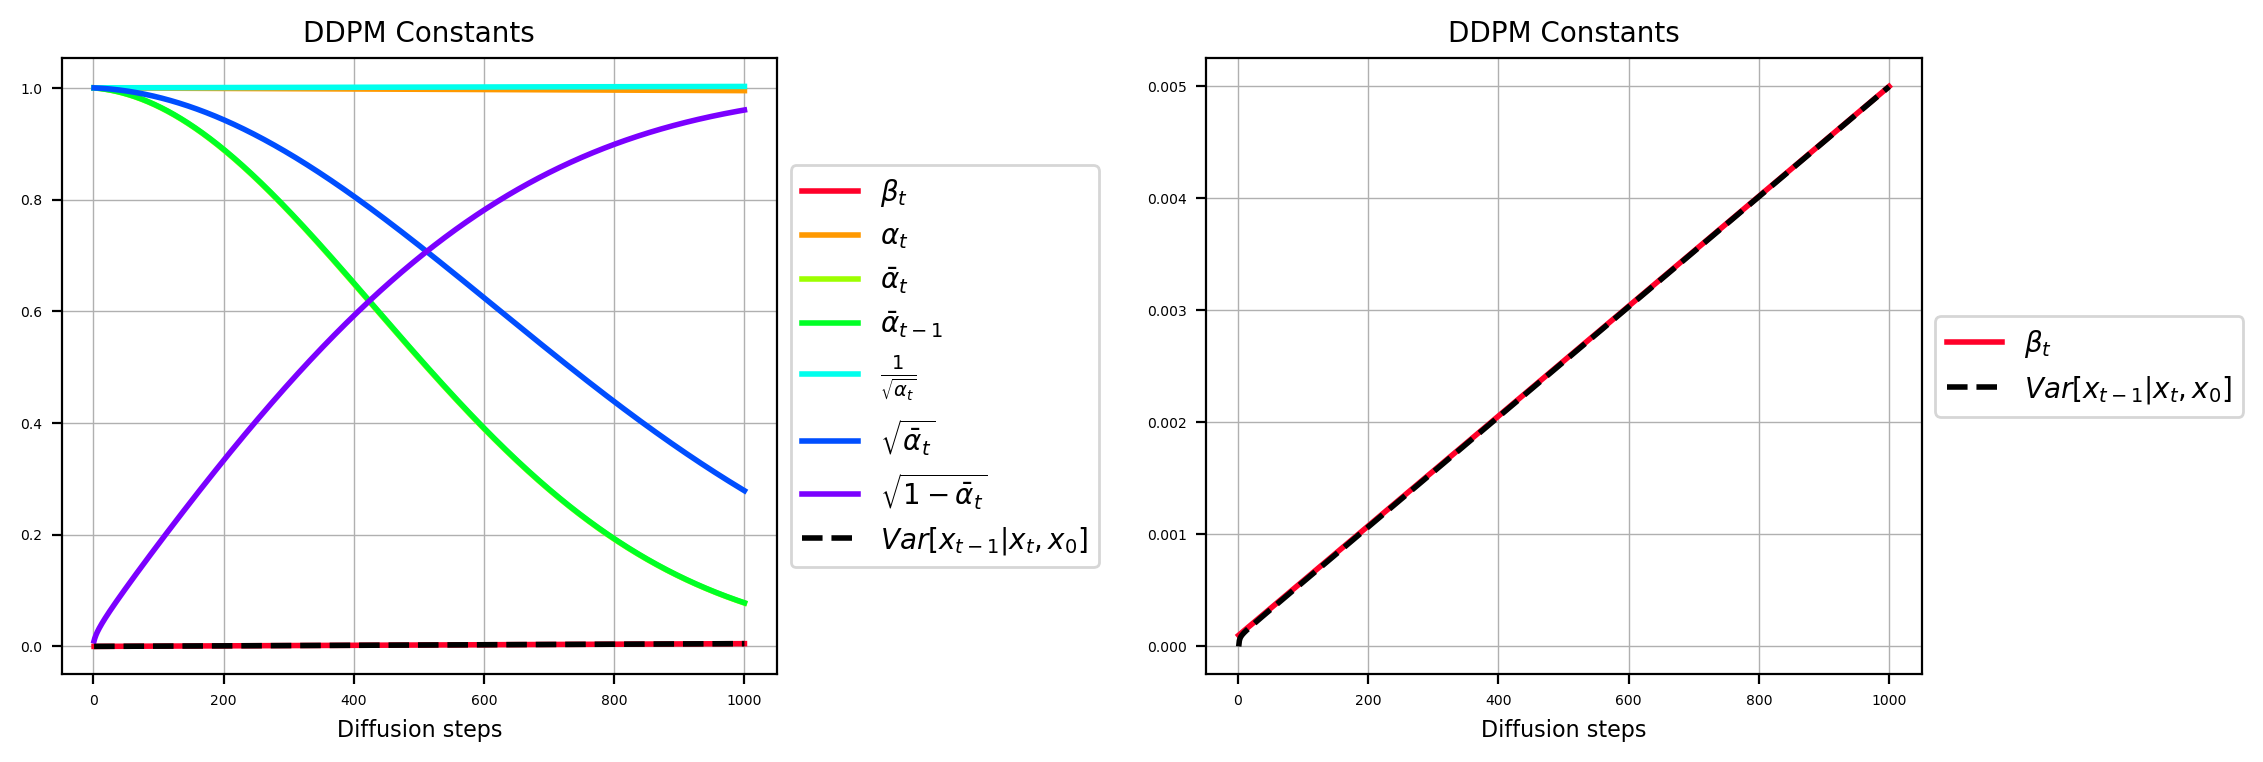

In [2]:
# Smaller `beta_end` tends to show better performances
dc = get_ddpm_constants(beta_start=1e-4,beta_end=5e-3,diffusion_step=1000)
plot_ddpm_constants(dc,figsize=(12,4))

#### Commmon hyper-parameters

In [3]:
BATCH_SIZE,D,L = 32,1,100
base_lr,MAX_ITER = 1e-3,10000
actv = nn.ReLU() # nn.GELU(), nn.ReLU()
l1_w,l2_w,huber_w,smt_l1_w = 0.1,1.0,0.0,0.0
device = 'cpu' # cpu / mps
print ("Ready.")

Ready.


#### Training data

In [4]:
times = np.linspace(start=0.0,stop=1.0,num=L).reshape((-1,1)) # [L x 1]
np.random.seed(seed=3)
x_0_np = gp_sampler(times=times,hyp_gain=1.0,hyp_len=0.2,meas_std=1e-8,n_traj=D).T # [D x L]
x_0 = np2torch(x_0_np,device=device) # [D x L]
x_batch = torch.tile(x_0[None,:,:],dims=(BATCH_SIZE,1,1)) # [B x D x L]
print ("Ready.")

Ready.


### Correlated noise sampling using Gaussian processes

[0/10000][0.00%] loss:[1.450]


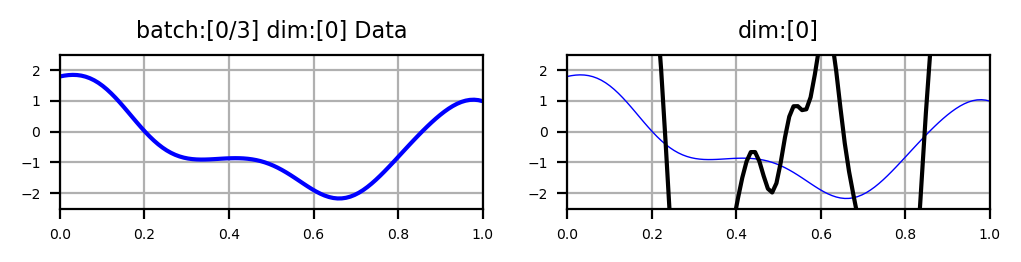

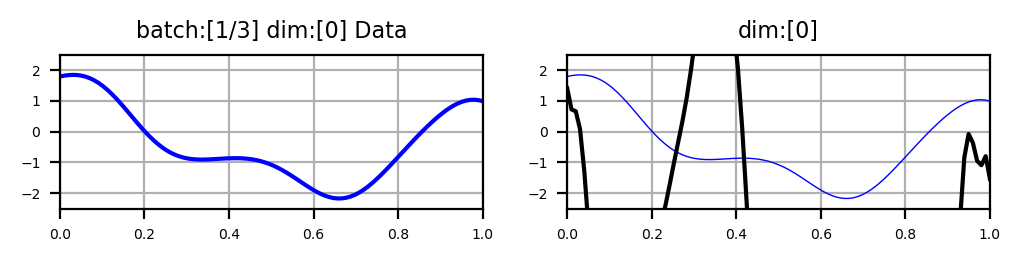

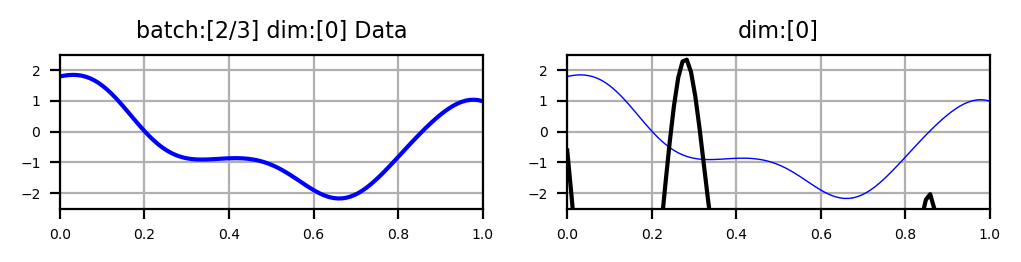

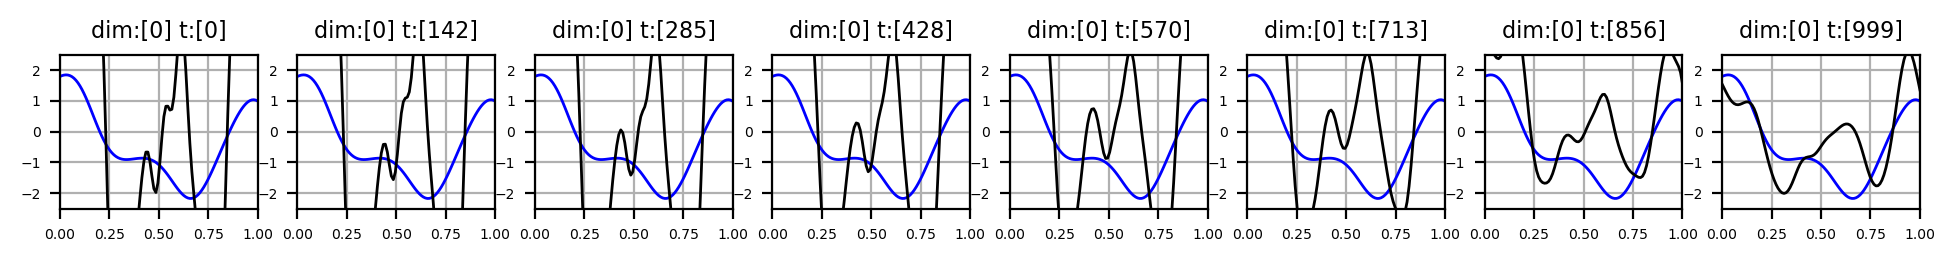

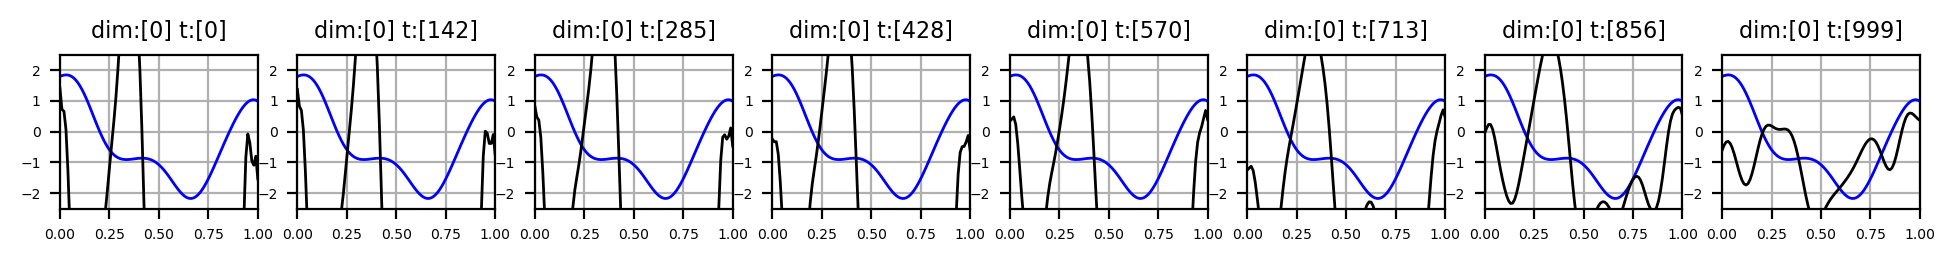

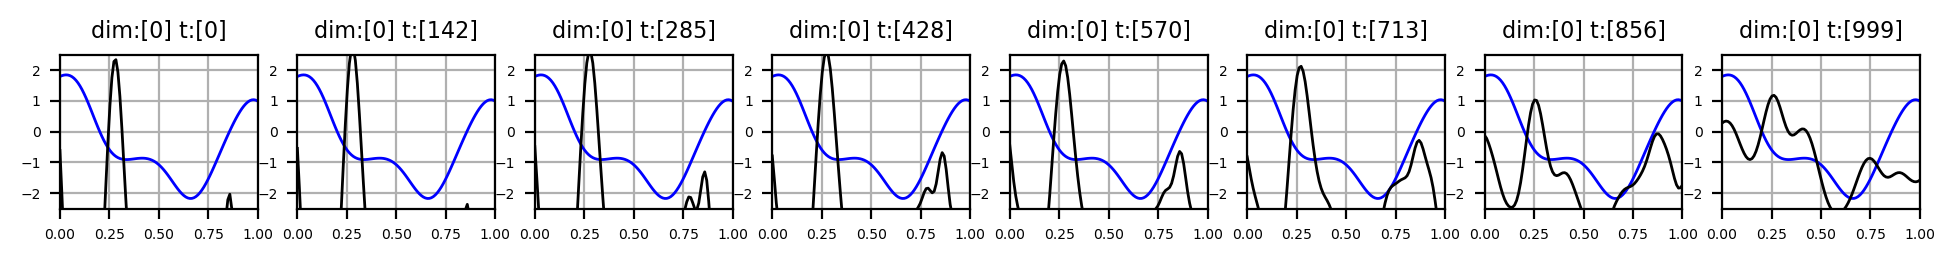

[500/10000][5.00%] loss:[0.129]
[1000/10000][10.00%] loss:[0.100]
[1500/10000][15.00%] loss:[0.149]
[2000/10000][20.00%] loss:[0.059]


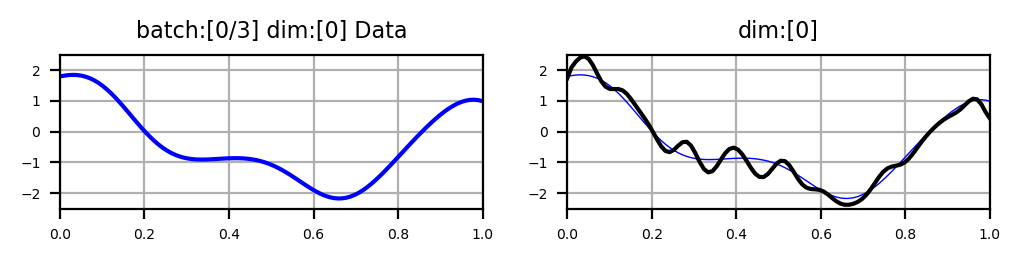

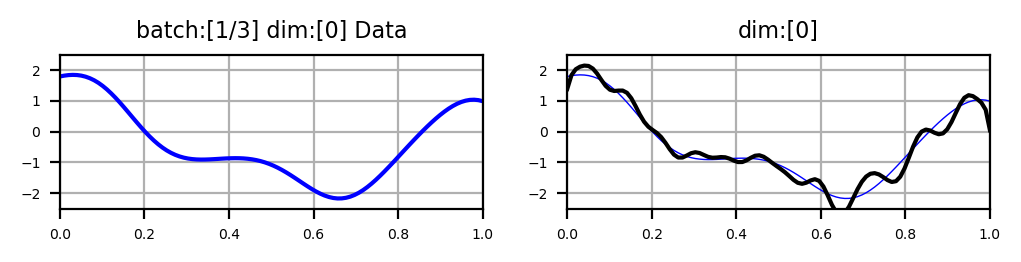

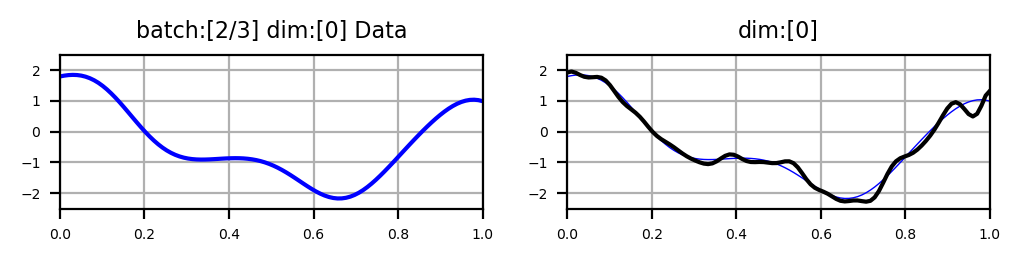

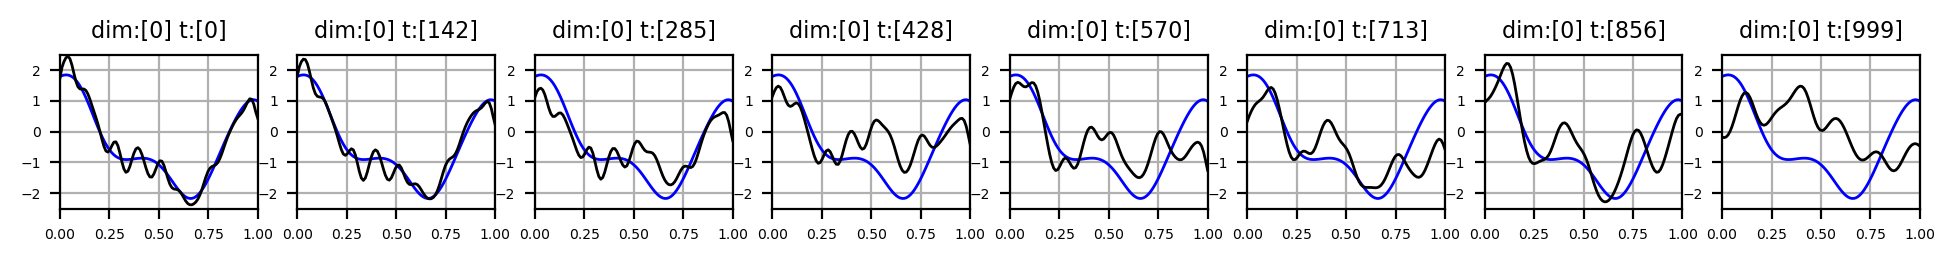

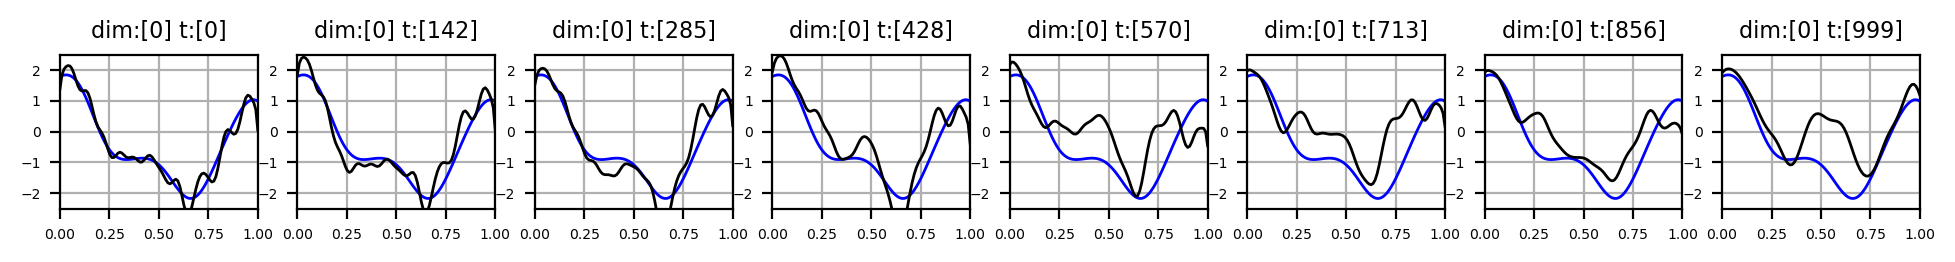

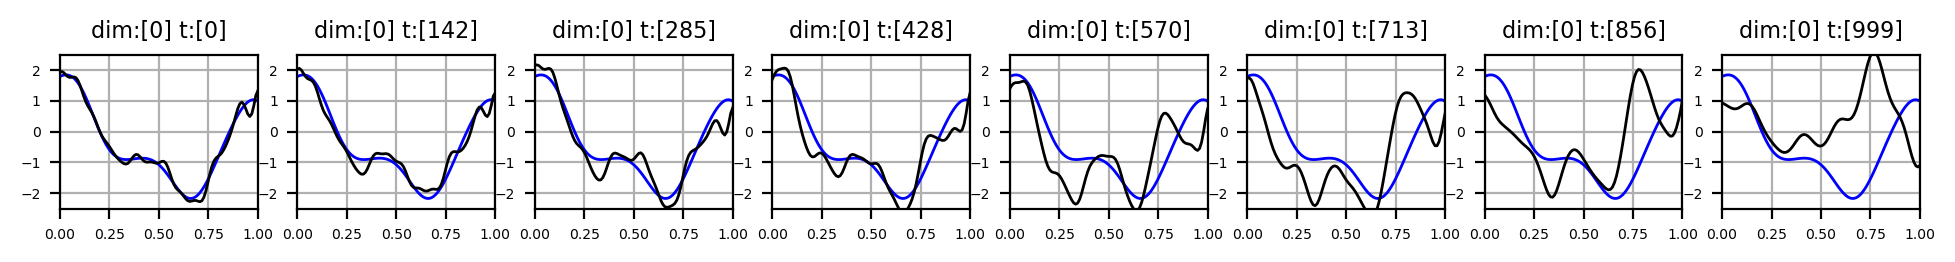

[2500/10000][25.00%] loss:[0.132]
[3000/10000][30.00%] loss:[0.076]
[3500/10000][35.00%] loss:[0.103]
[4000/10000][40.00%] loss:[0.108]


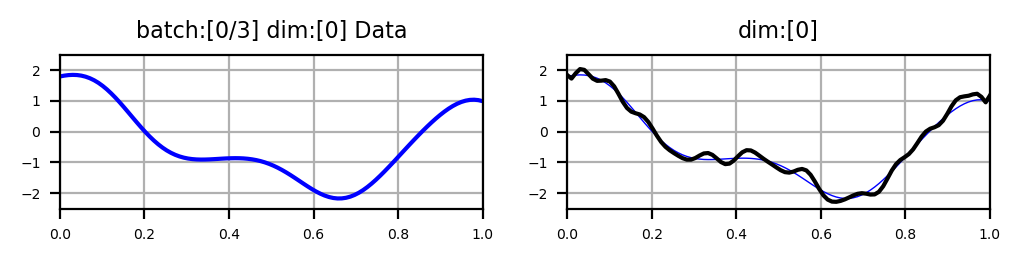

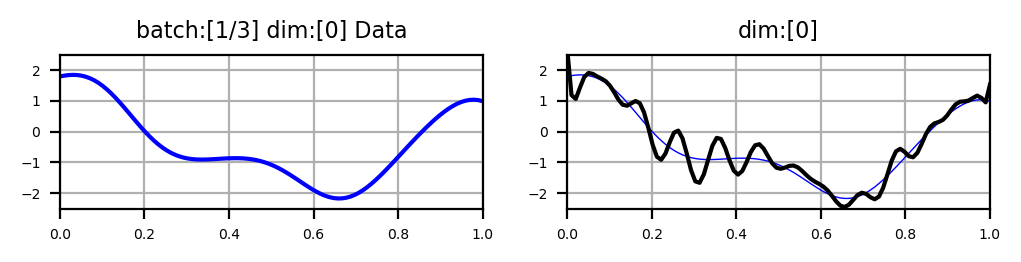

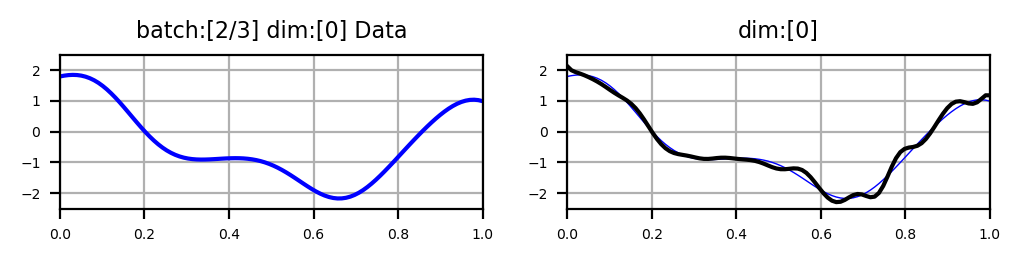

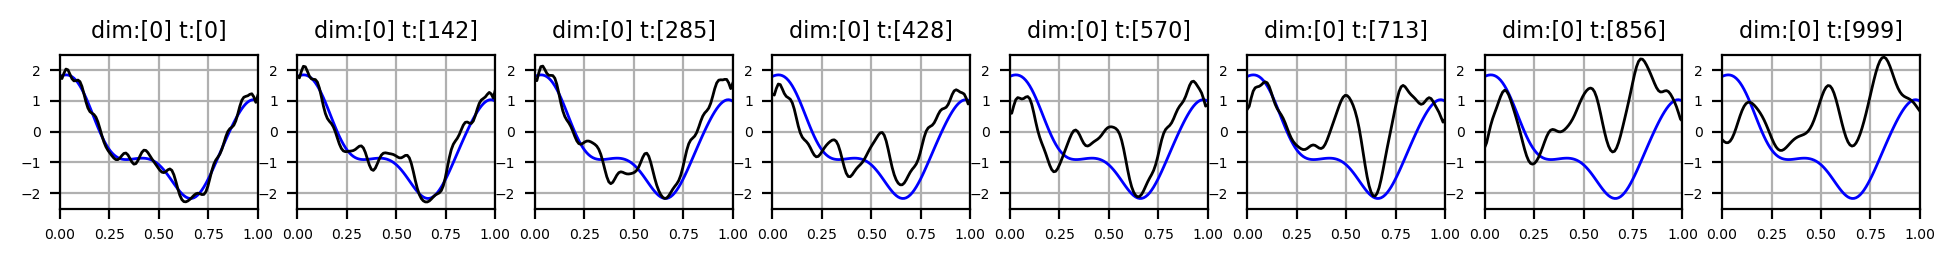

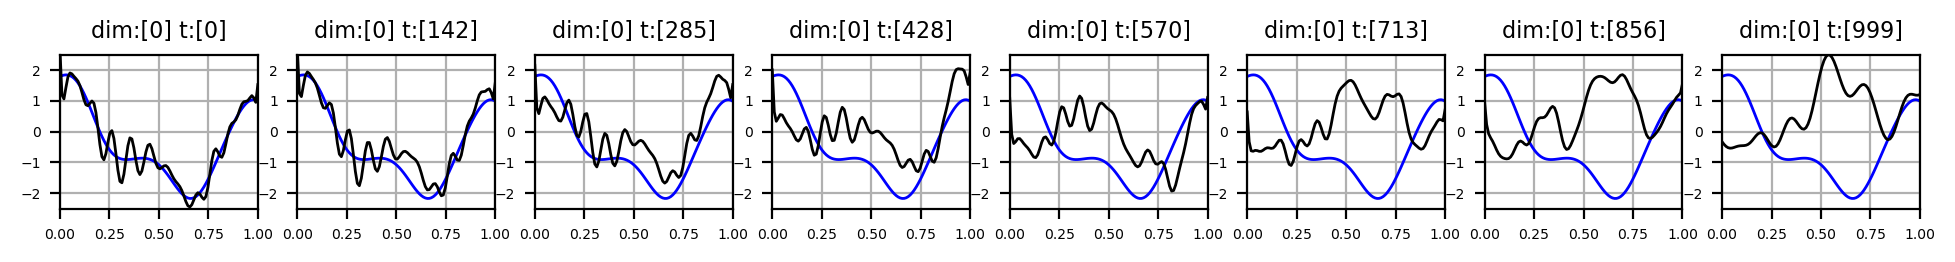

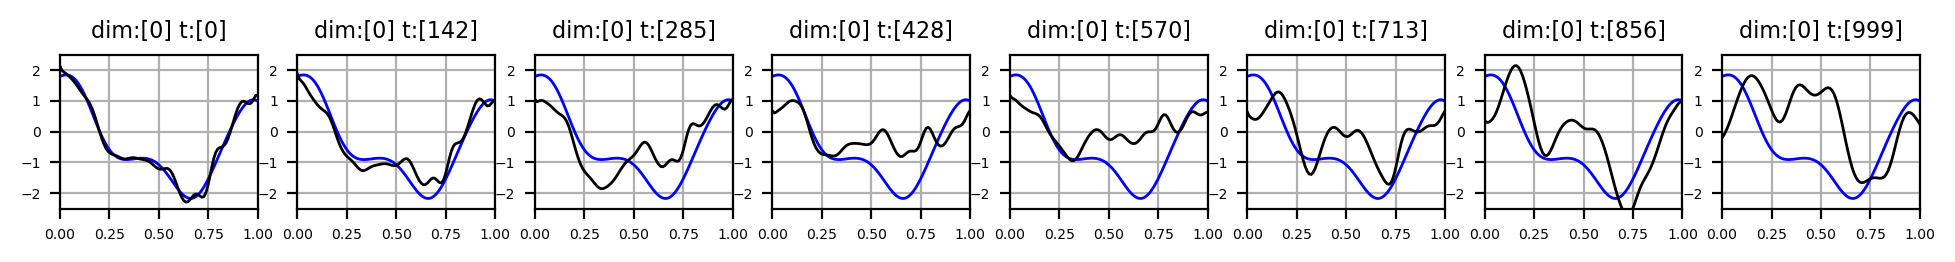

[4500/10000][45.00%] loss:[0.084]
[5000/10000][50.00%] loss:[0.079]
[5500/10000][55.00%] loss:[0.077]
[6000/10000][60.00%] loss:[0.071]


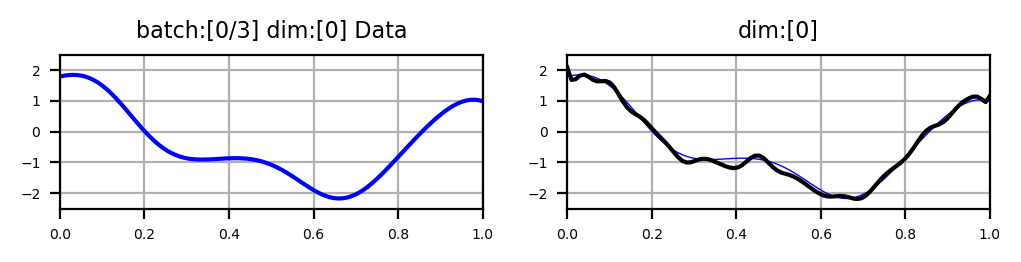

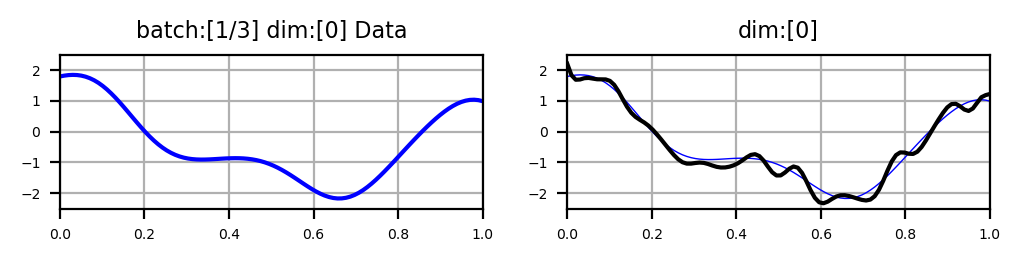

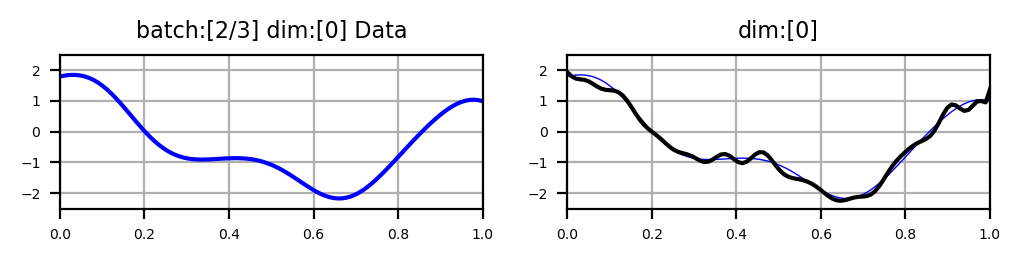

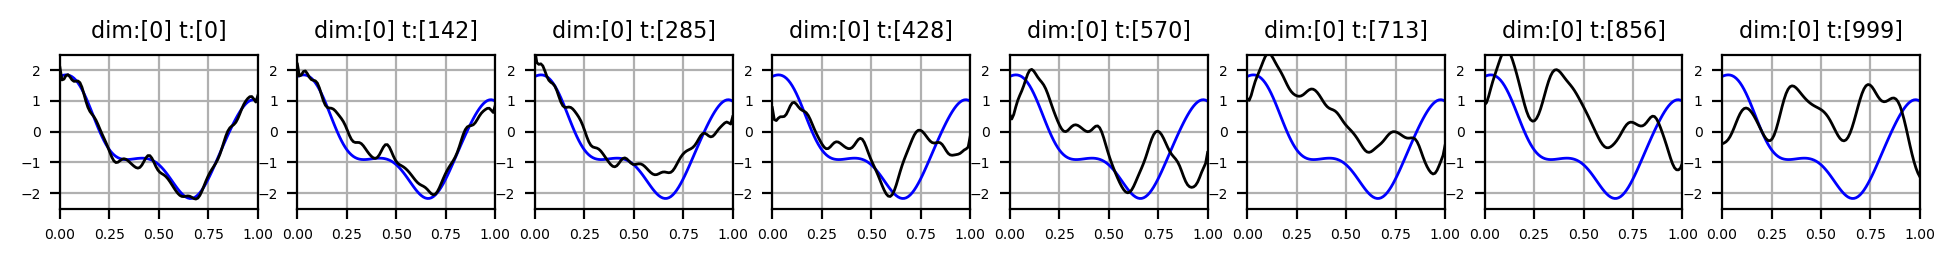

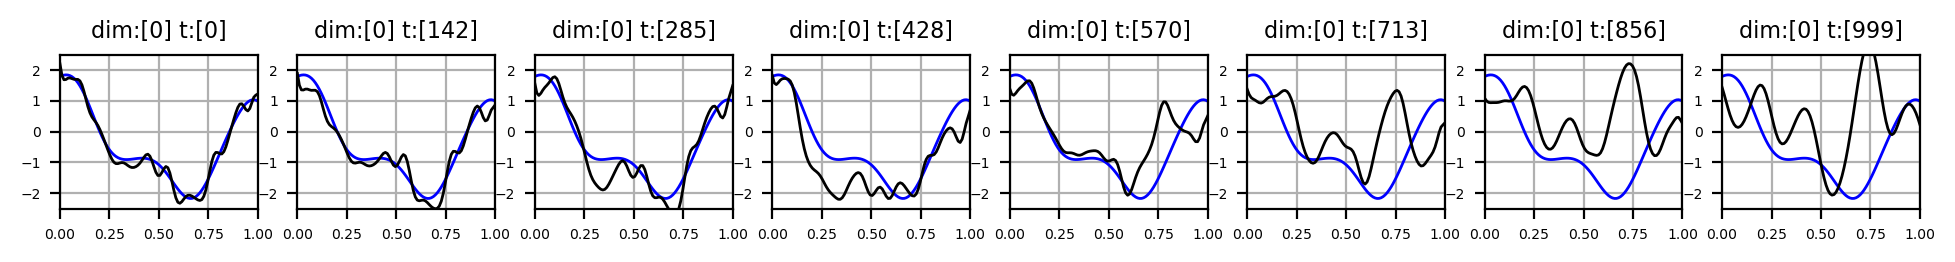

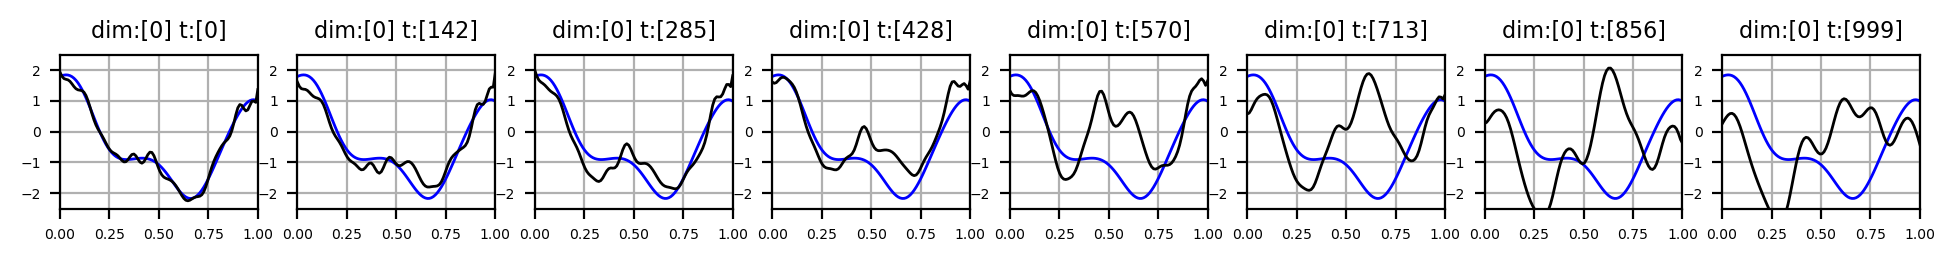

[6500/10000][65.00%] loss:[0.075]
[7000/10000][70.00%] loss:[0.077]
[7500/10000][75.00%] loss:[0.092]
[8000/10000][80.00%] loss:[0.092]


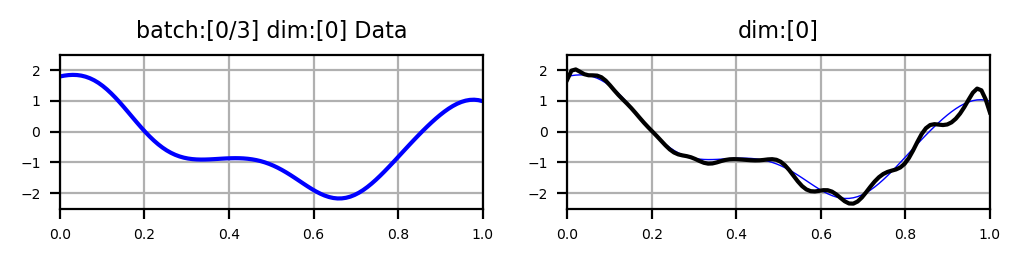

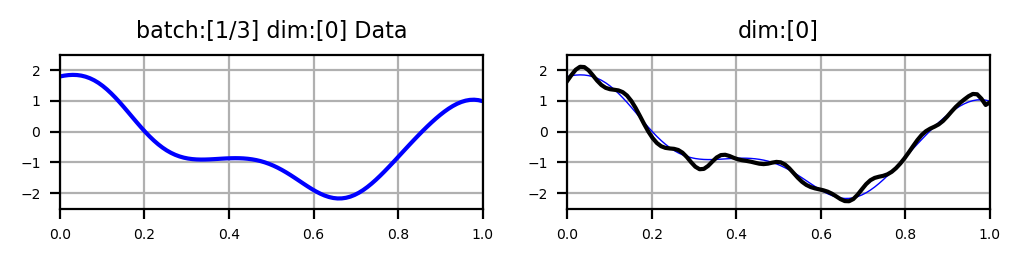

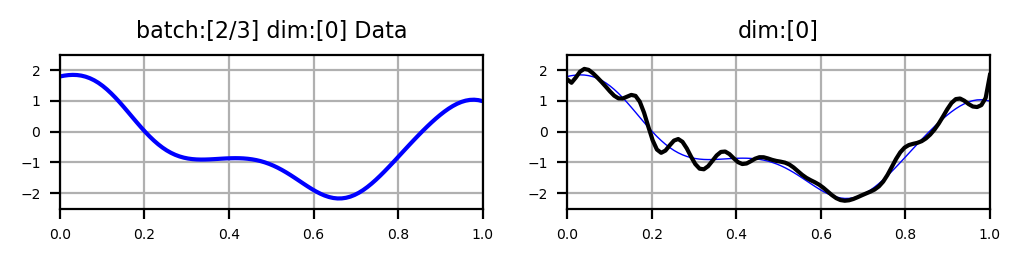

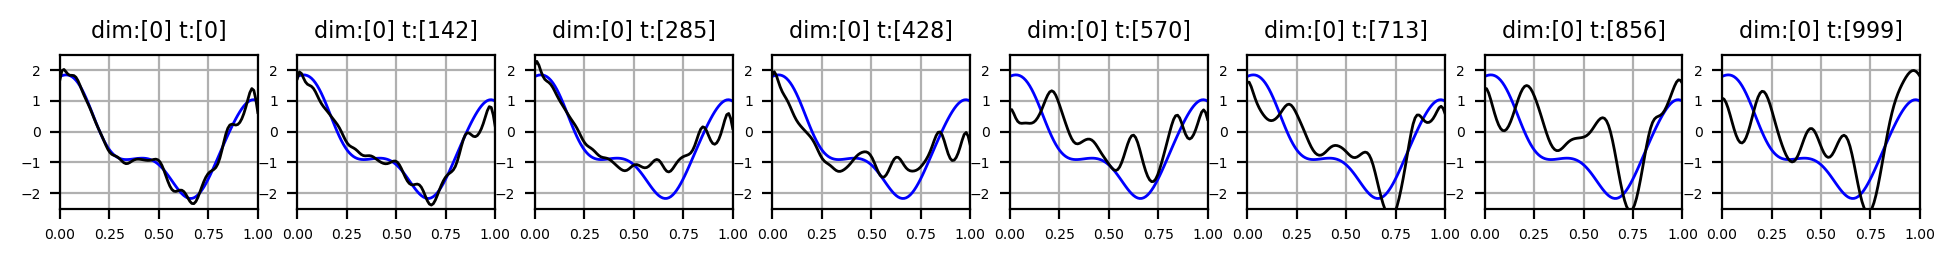

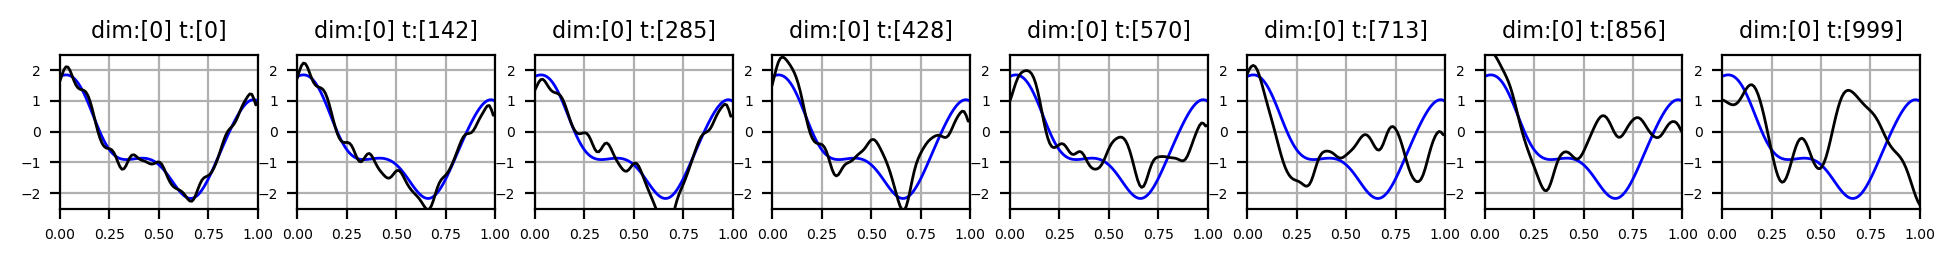

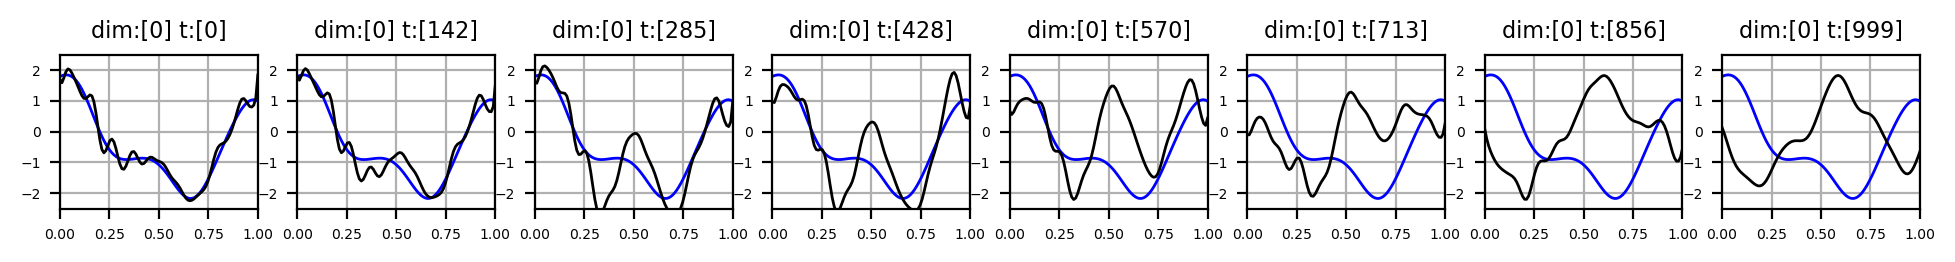

[8500/10000][85.00%] loss:[0.122]
[9000/10000][90.00%] loss:[0.098]
[9500/10000][95.00%] loss:[0.090]
[9999/10000][99.99%] loss:[0.081]


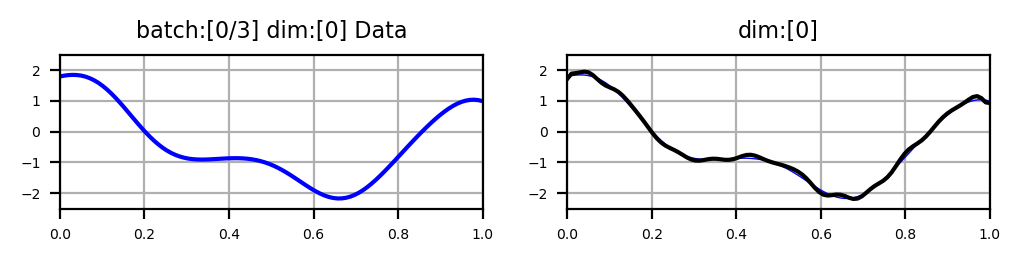

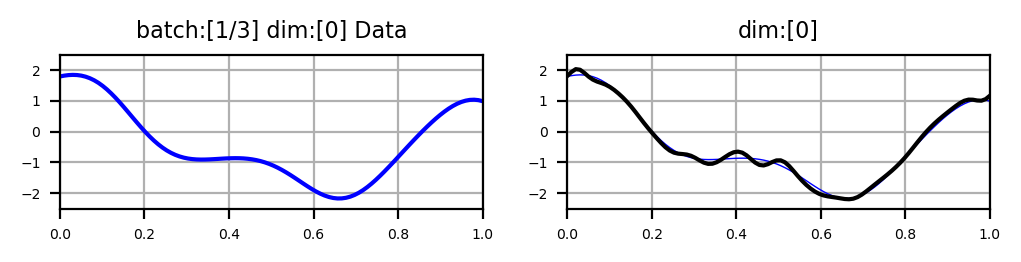

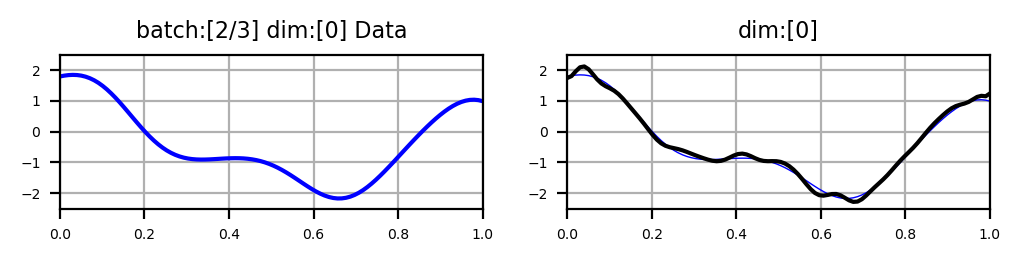

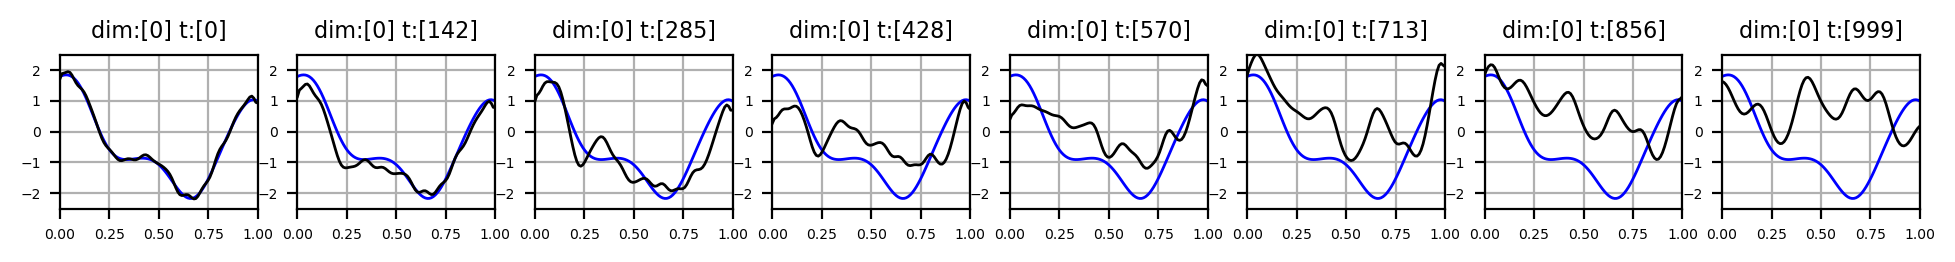

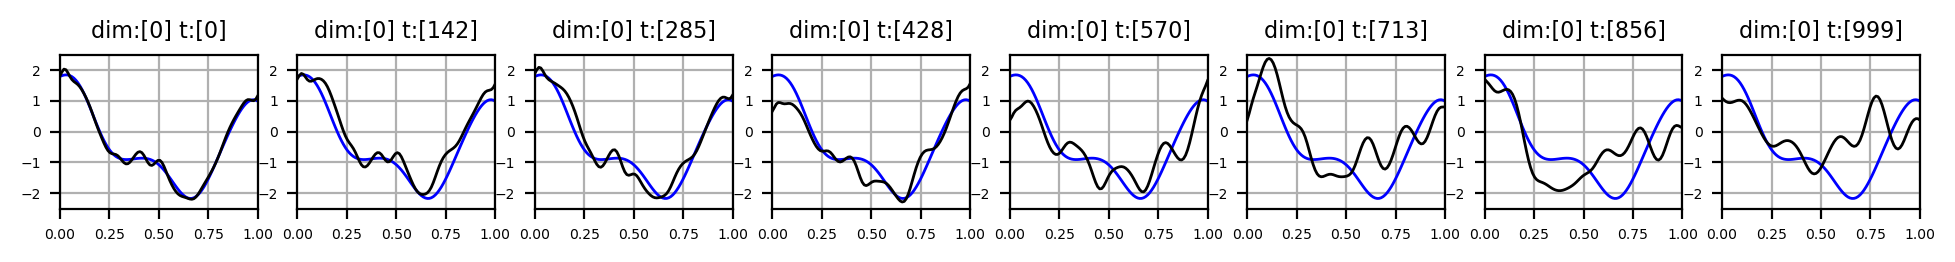

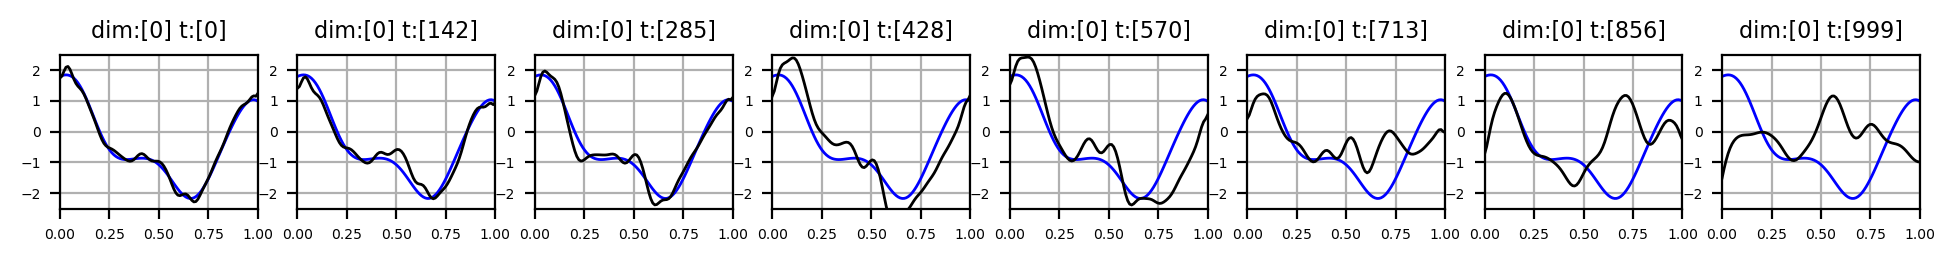

Done.


In [5]:
# Set Hilbert forward process
hyp_lens = [0.1]*D # length parameter per each dimension
K_chols_np = np.zeros(shape=(D,L,L)) # [D x L x L]
for d_idx in range(D):
    hyp_len = hyp_lens[d_idx]
    K = kernel_se(times,times,hyp={'gain':1.0,'len':hyp_len})
    K_chols_np[d_idx,:,:] = np.linalg.cholesky(K+1e-8*np.eye(L,L)) # [L x L]
K_chols = np2torch(K_chols_np,device=device) # [D x L x L]
# Set RHKS projections
RKHS_projs_np = np.zeros(shape=(D,L,L)) # [D x L x L]
for d_idx in range(D):
    hyp_len = hyp_lens[d_idx]
    RKHS_projs_np[d_idx,:,:] = get_rkhs_proj(times=times,hyp_len=hyp_len,meas_std=1e-6) # [L x L]
RKHS_projs = np2torch(RKHS_projs_np,device=device) # [D x L x L]
# Model
model = DenoisingDenseUNetClass(
    D=D,L=L,pos_emb_dim=32,h_dims=[128,64,32],z_dim=32,
    actv=actv,USE_POS_EMB=True,RKHS_projs=RKHS_projs)
model.to(device)
# Train
model.train()
optm = torch.optim.Adam(
    model.parameters(),lr=base_lr,betas=(0.9, 0.999),eps=1e-03,weight_decay=1e-08)
lr_schd = torch.optim.lr_scheduler.StepLR(optm,step_size=int(0.4*MAX_ITER),gamma=0.5)
for it in range(MAX_ITER):
    optm.zero_grad()
    t = torch.randint(0, dc['T'],(BATCH_SIZE,),device=device).long() # [B]
    loss = get_ddpm_loss(
        model=model,x_0=x_batch,K_chols=K_chols,t=t,dc=dc,noise_rate=1.0,
        RKHS_projs=RKHS_projs,noise_type='Gaussian',
        l1_w=l1_w,l2_w=l2_w,huber_w=huber_w,smt_l1_w=huber_w)
    loss.backward(); optm.step(); lr_schd.step()
    if ((it % (MAX_ITER//20)) == 0) or (it==(MAX_ITER-1)):
        print ("[%d/%d][%.2f%%] loss:[%.3f]"%(it,MAX_ITER,100*it/MAX_ITER,loss.item()))
    if ((it % (MAX_ITER//5)) == 0) or (it==(MAX_ITER-1)):
        eval_hddpm_1D(
            model,dc,K_chols,RKHS_projs,times,x_0,
            B=3,M=8,device=device,
            RKHS_PROJECTION_EACH_X_T=False)
print ("Done.")

### Baseline

[0/10000][0.00%] loss:[2.083]


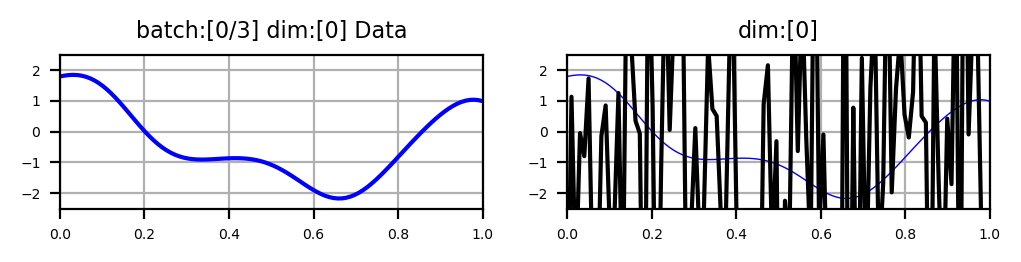

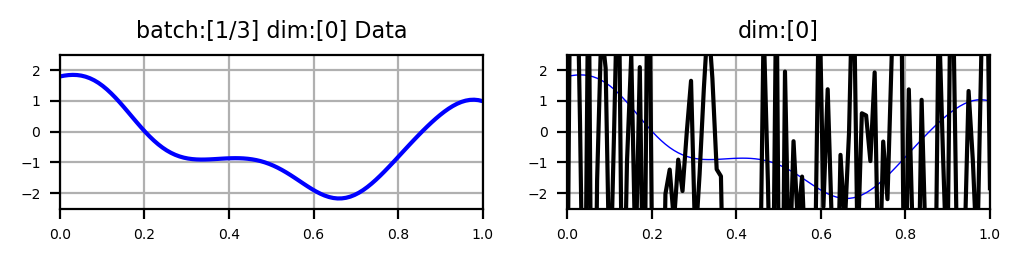

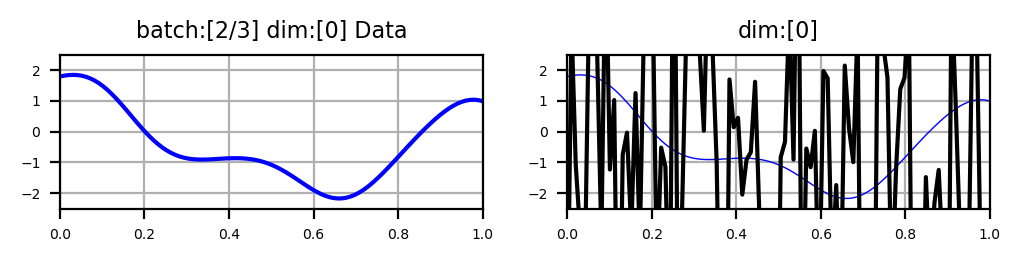

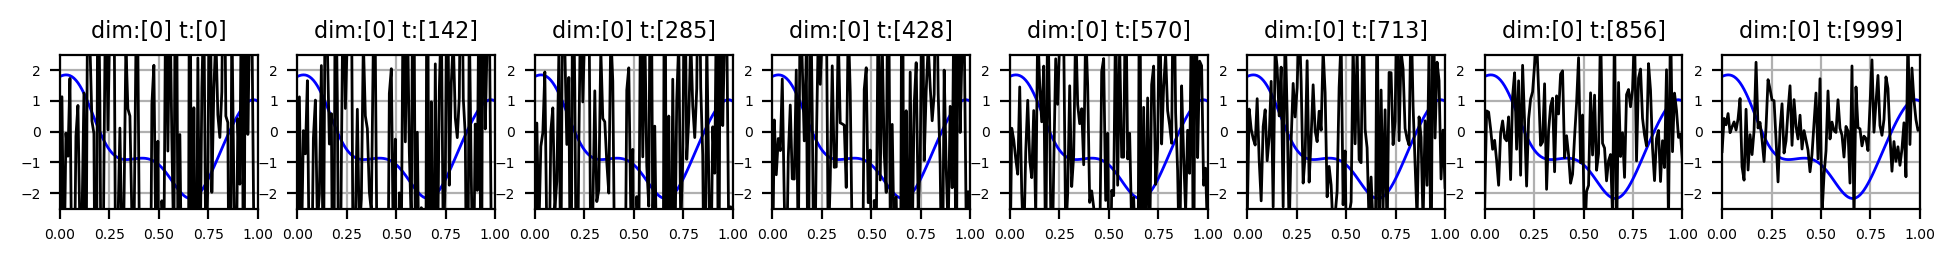

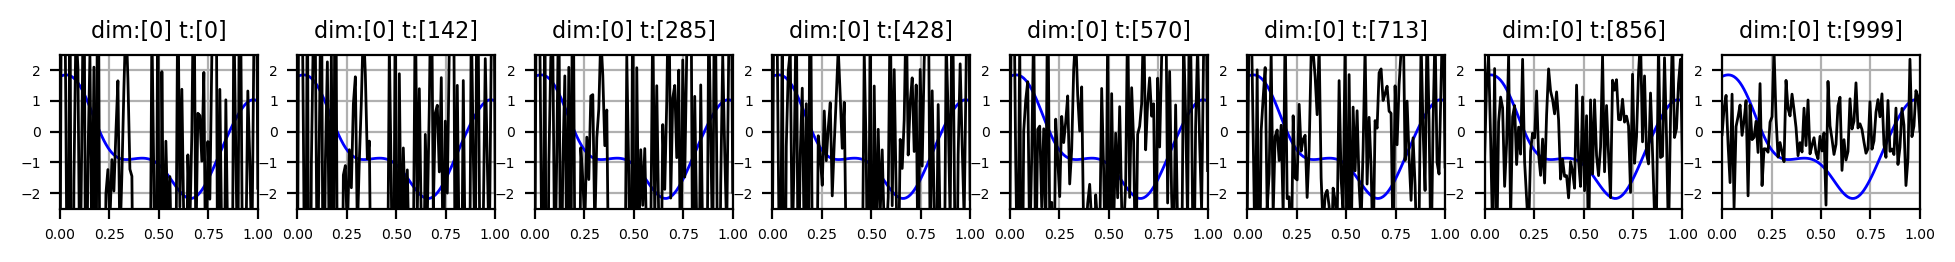

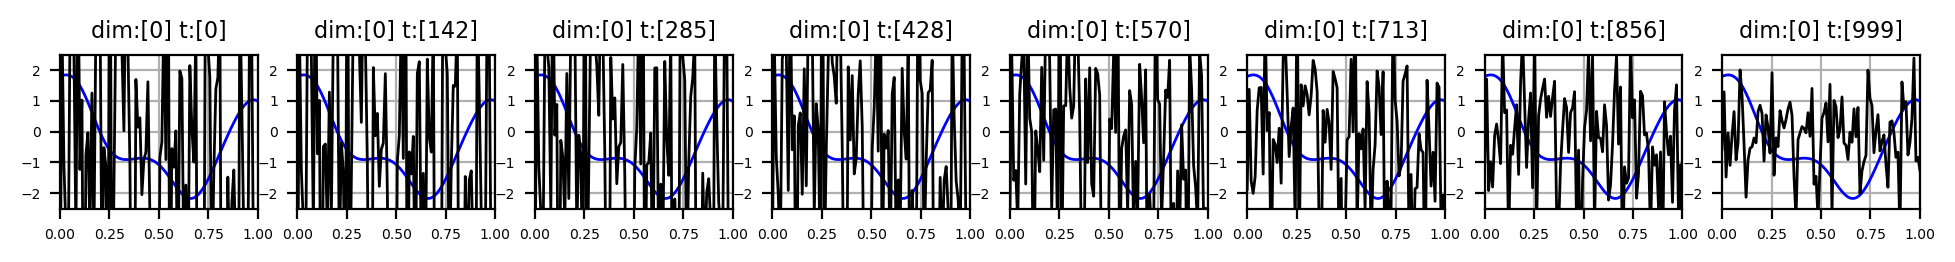

[500/10000][5.00%] loss:[0.369]
[1000/10000][10.00%] loss:[0.227]
[1500/10000][15.00%] loss:[0.265]
[2000/10000][20.00%] loss:[0.215]


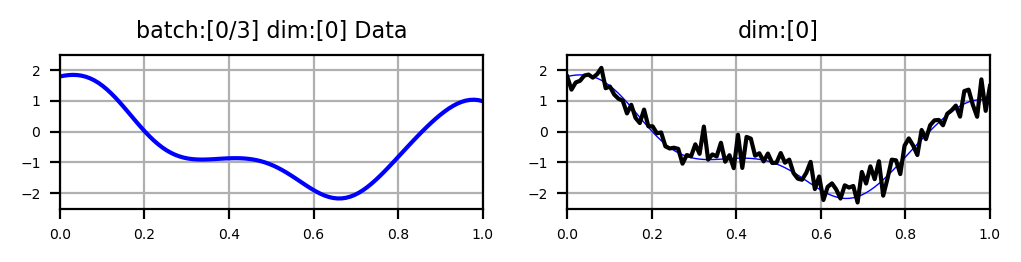

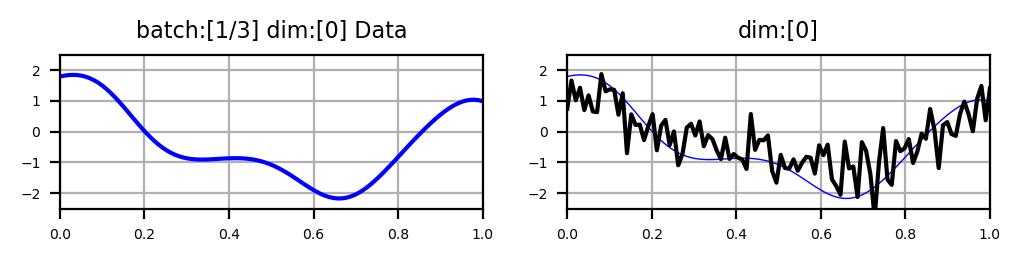

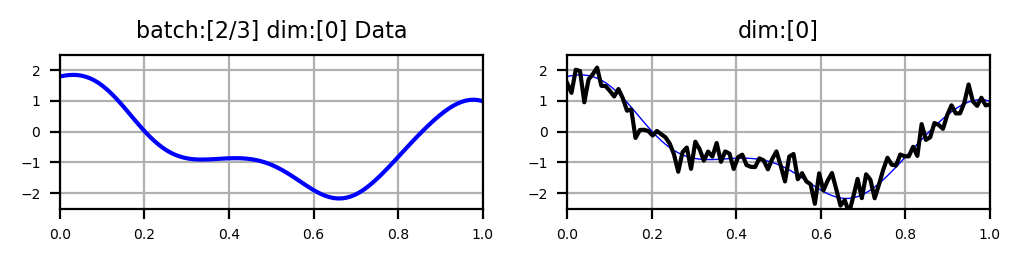

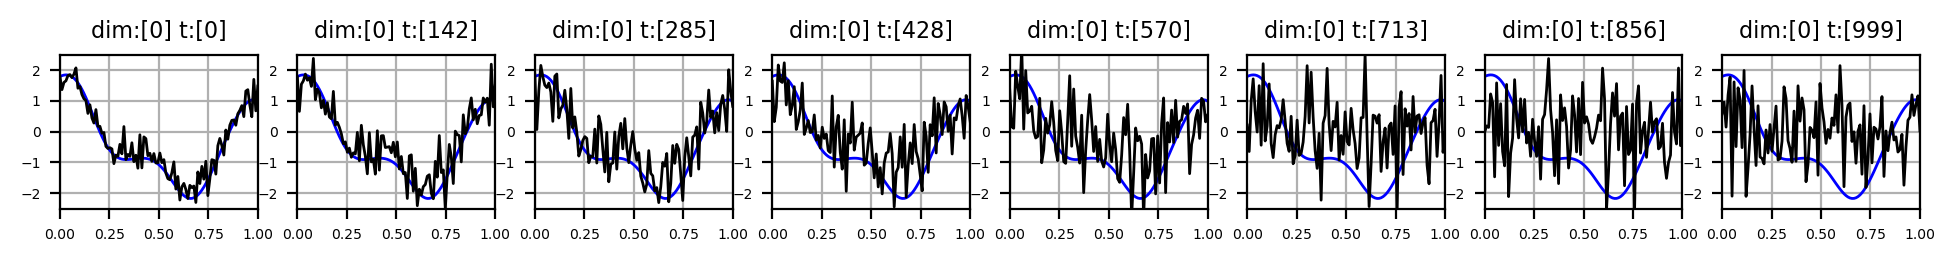

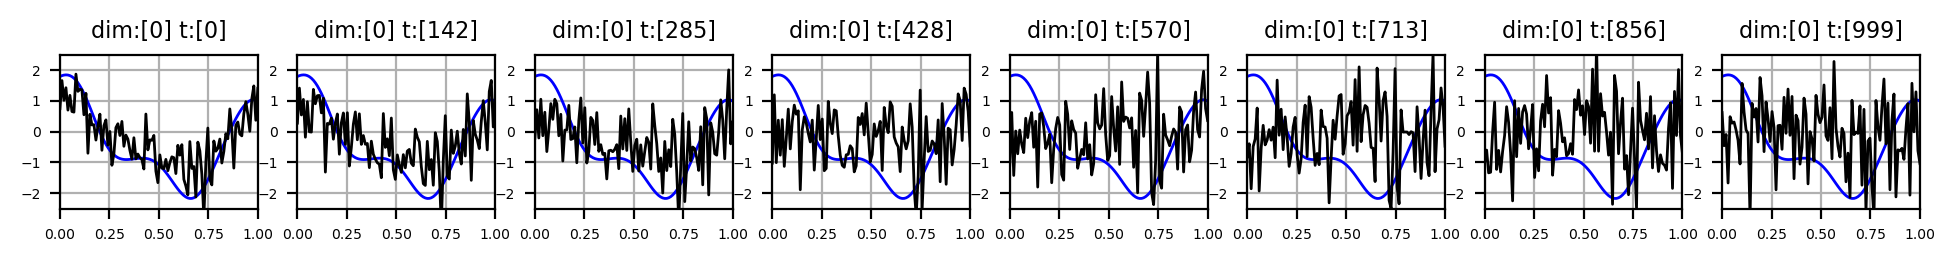

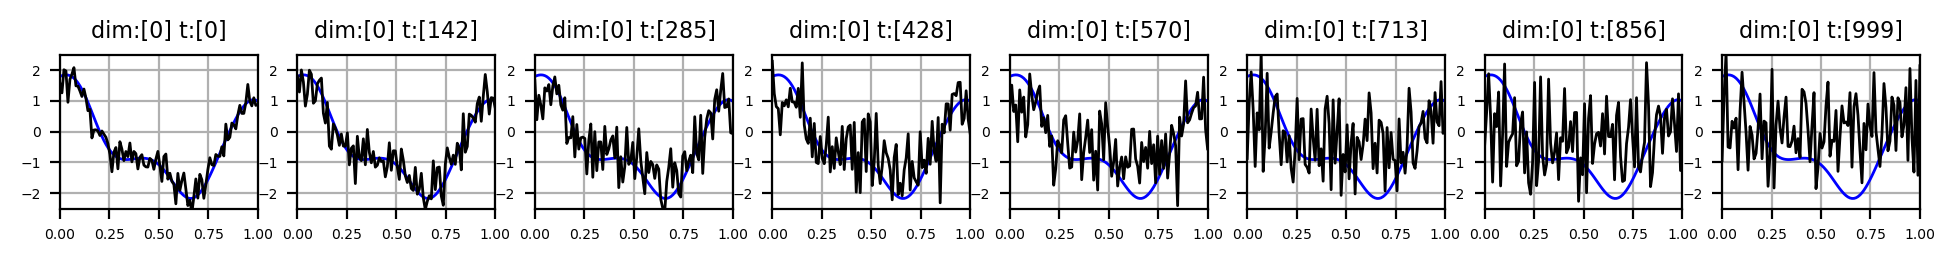

[2500/10000][25.00%] loss:[0.239]
[3000/10000][30.00%] loss:[0.200]
[3500/10000][35.00%] loss:[0.271]
[4000/10000][40.00%] loss:[0.201]


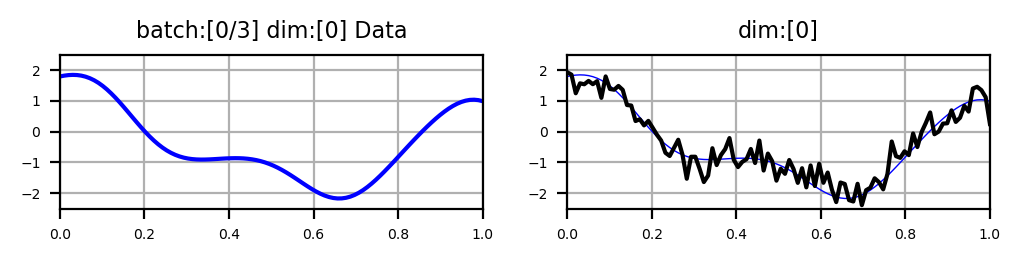

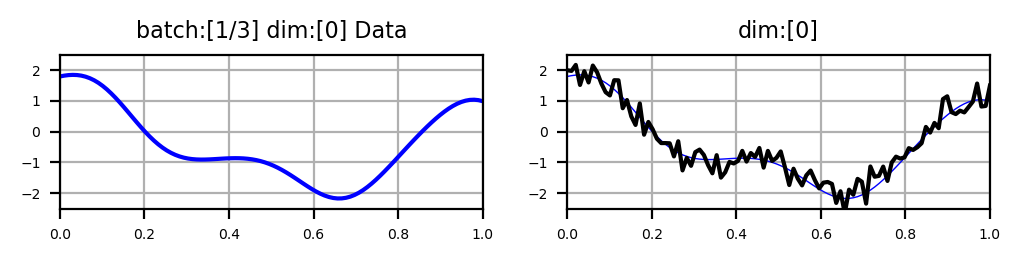

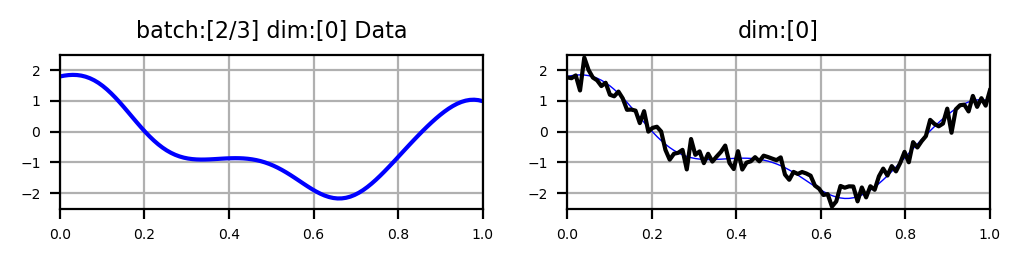

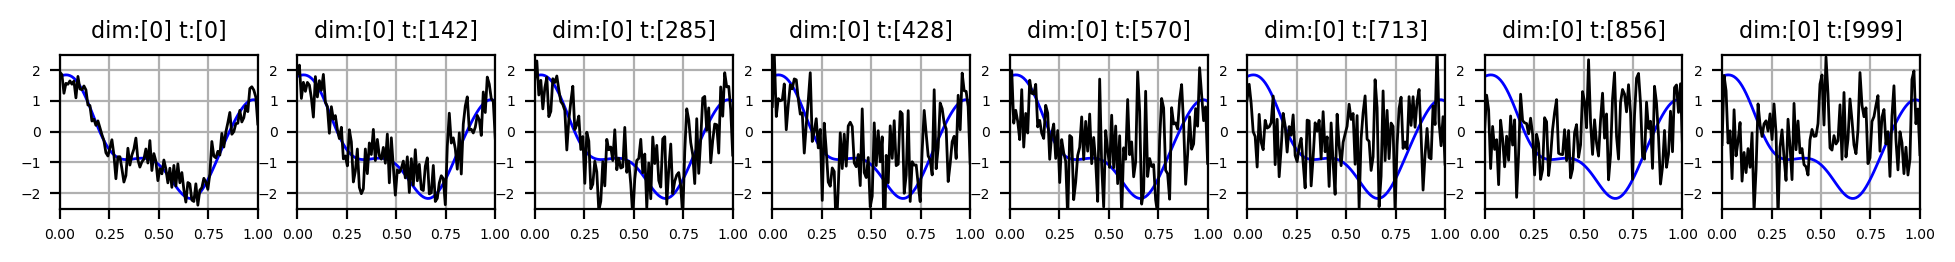

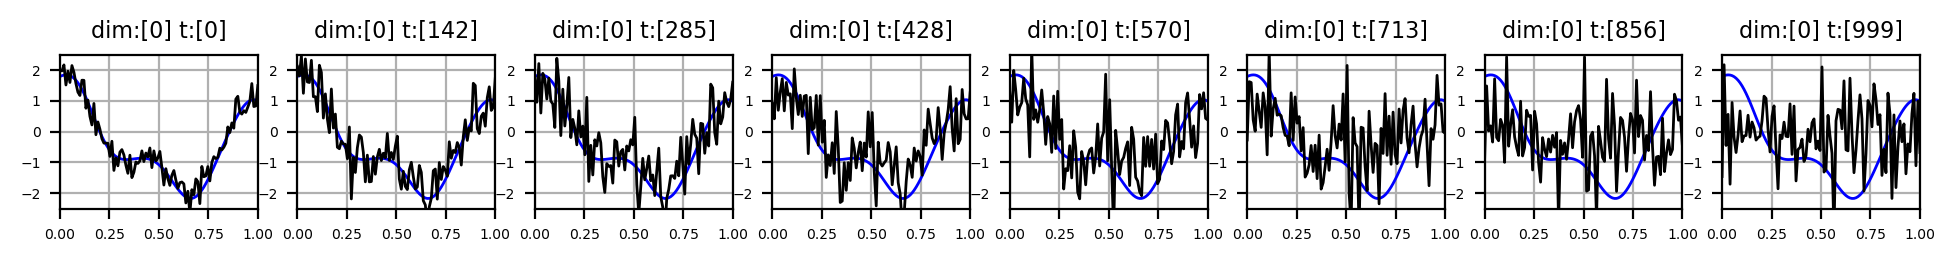

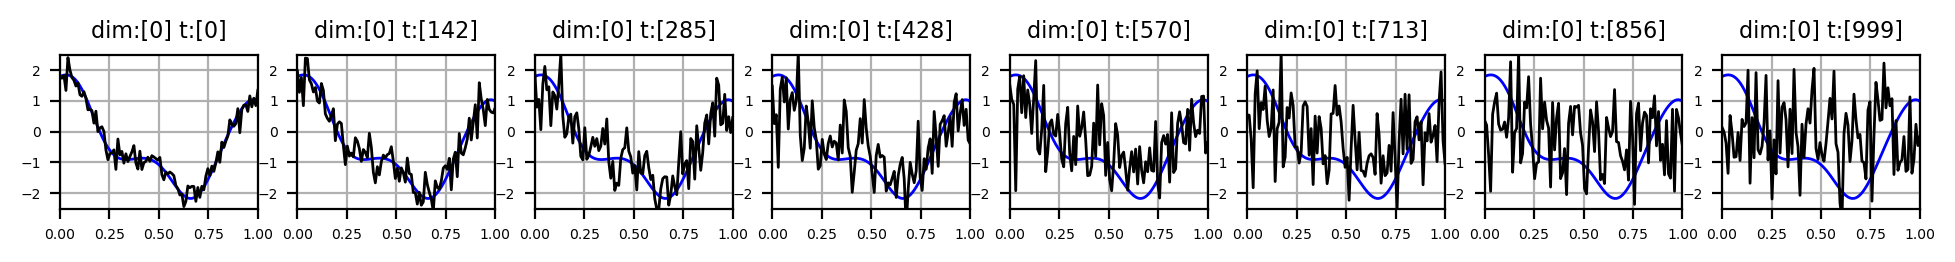

[4500/10000][45.00%] loss:[0.197]
[5000/10000][50.00%] loss:[0.174]
[5500/10000][55.00%] loss:[0.194]
[6000/10000][60.00%] loss:[0.215]


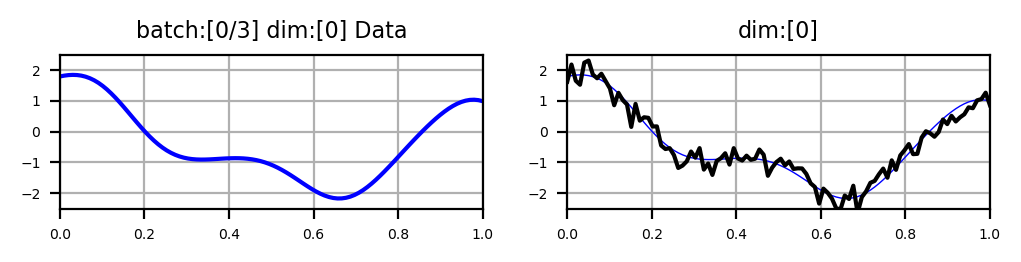

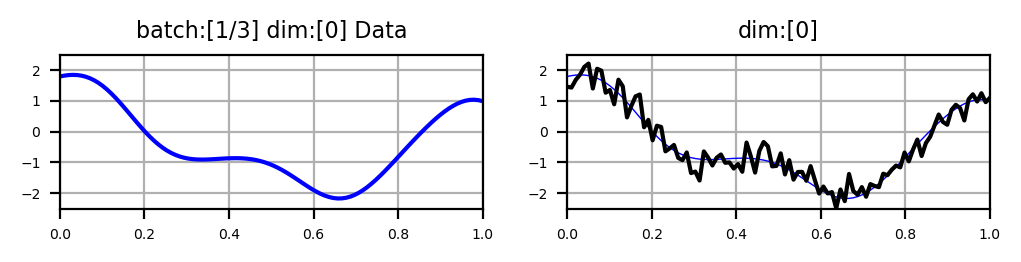

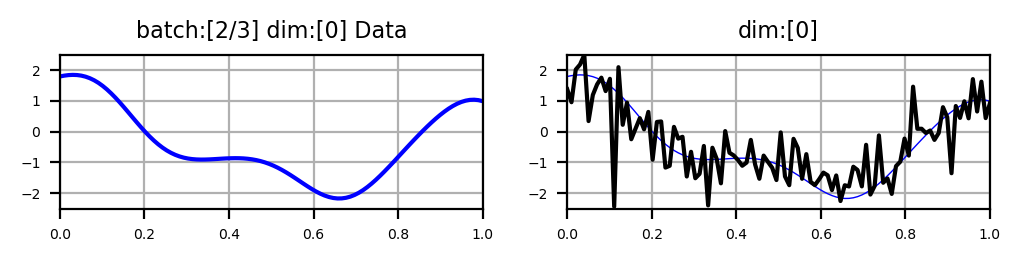

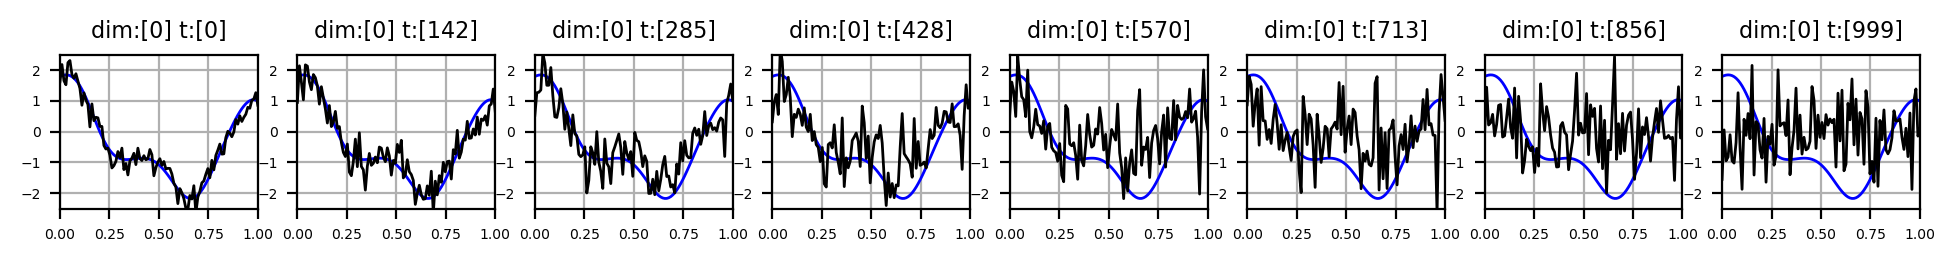

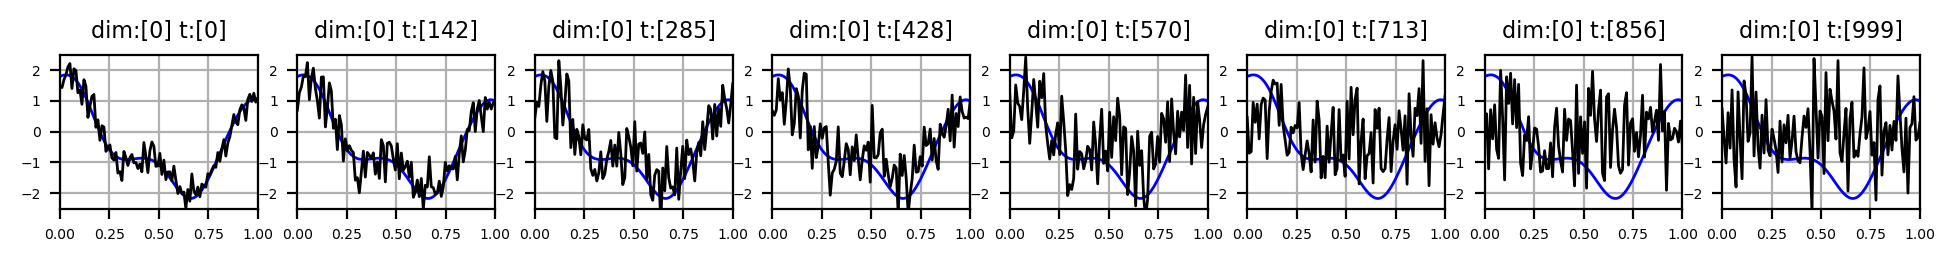

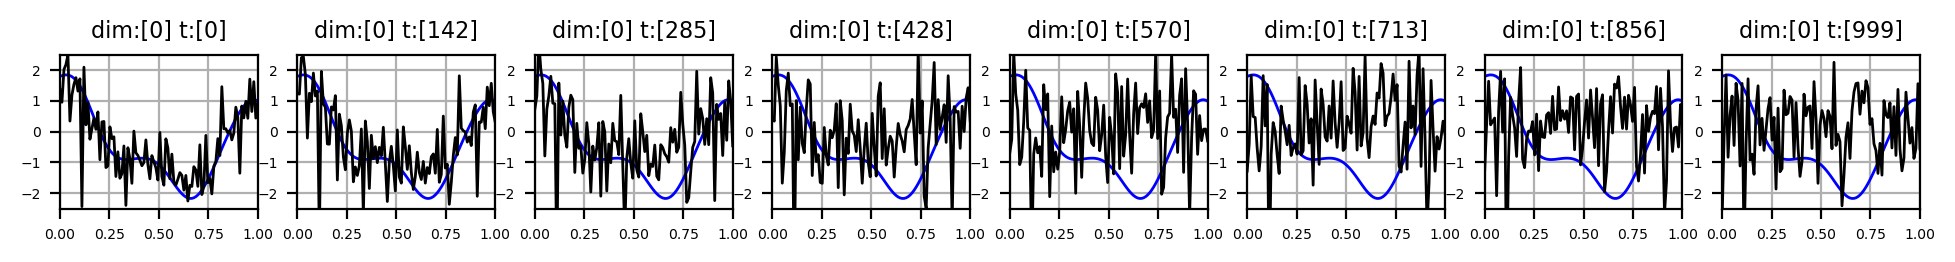

[6500/10000][65.00%] loss:[0.179]
[7000/10000][70.00%] loss:[0.174]
[7500/10000][75.00%] loss:[0.193]
[8000/10000][80.00%] loss:[0.211]


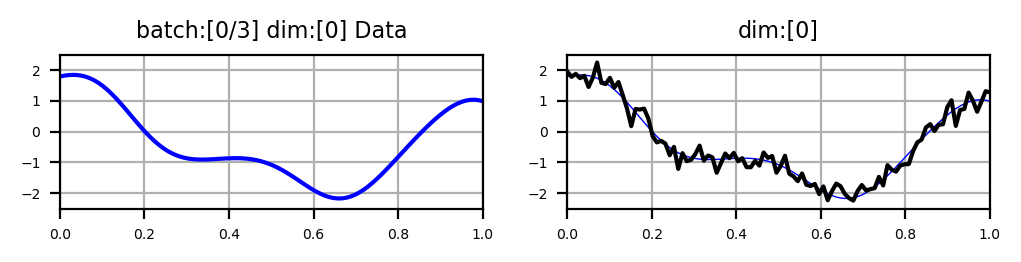

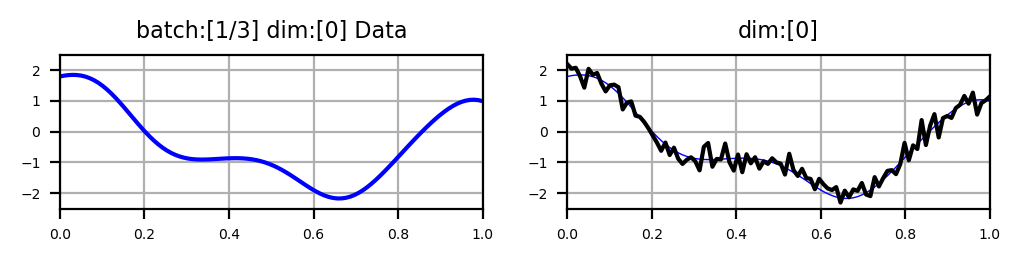

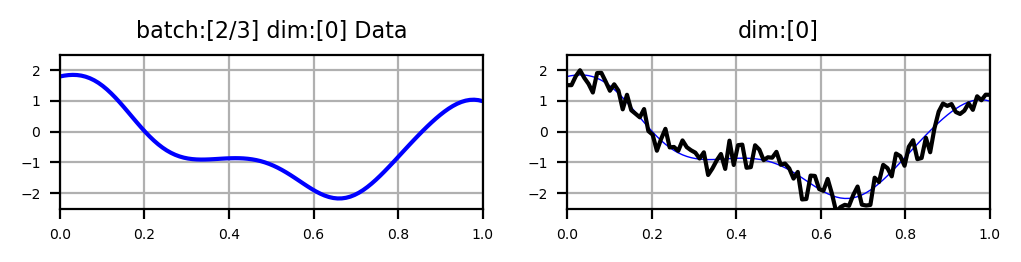

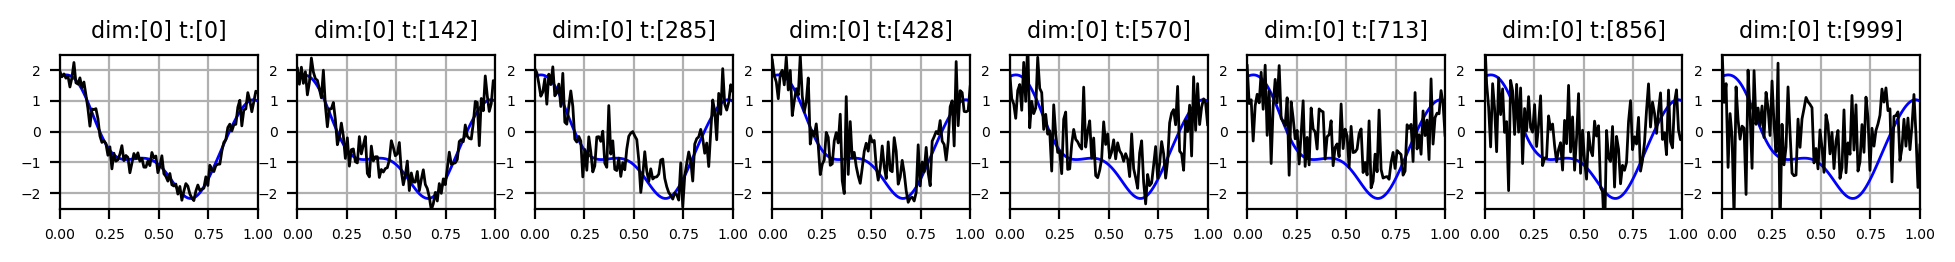

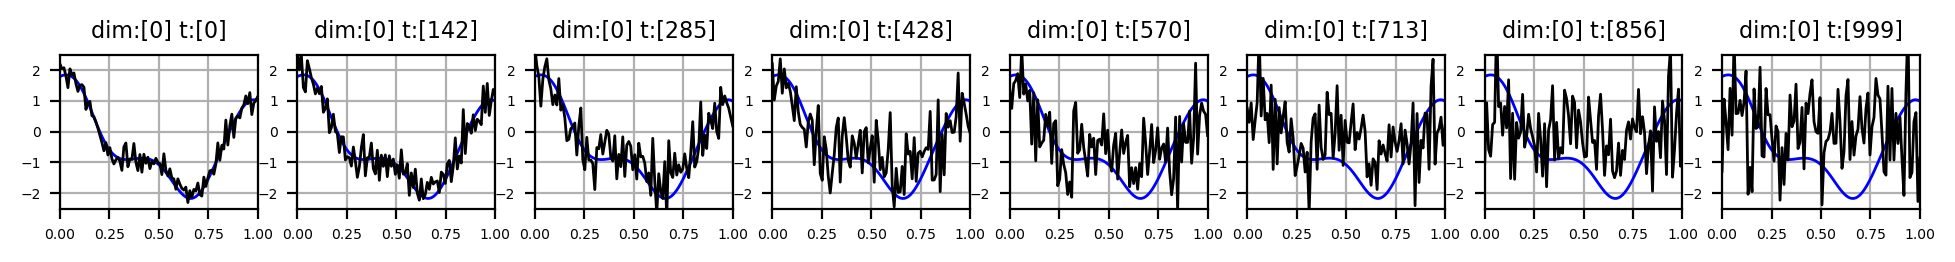

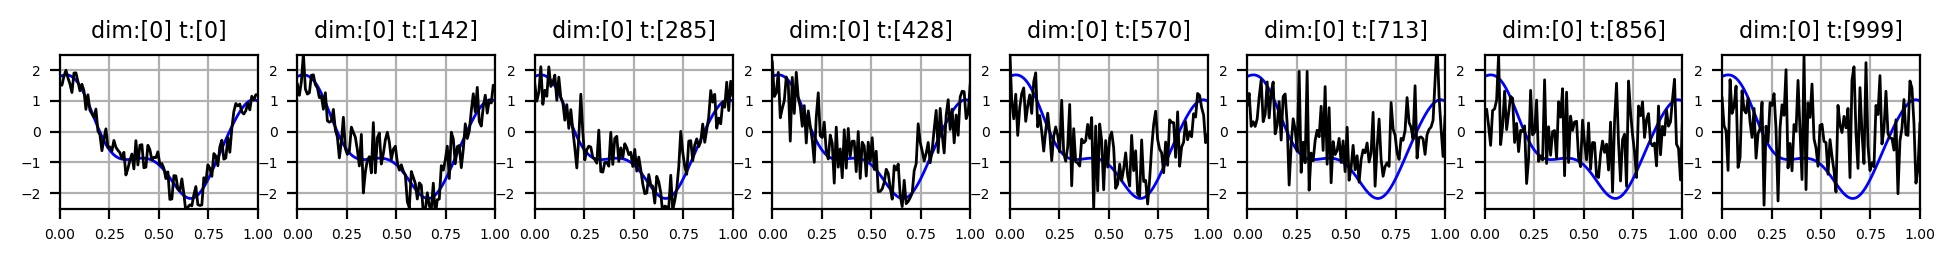

[8500/10000][85.00%] loss:[0.196]
[9000/10000][90.00%] loss:[0.268]
[9500/10000][95.00%] loss:[0.222]
[9999/10000][99.99%] loss:[0.243]


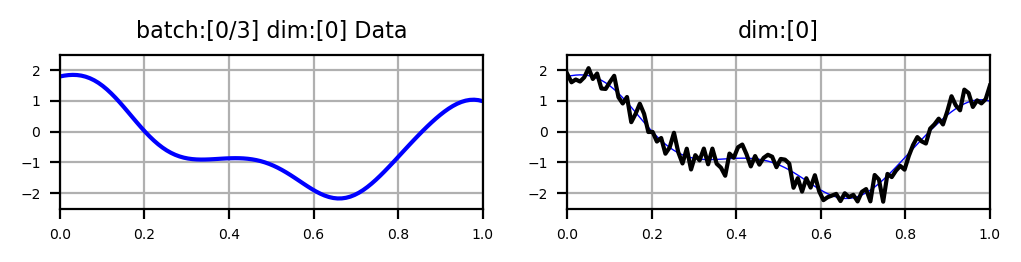

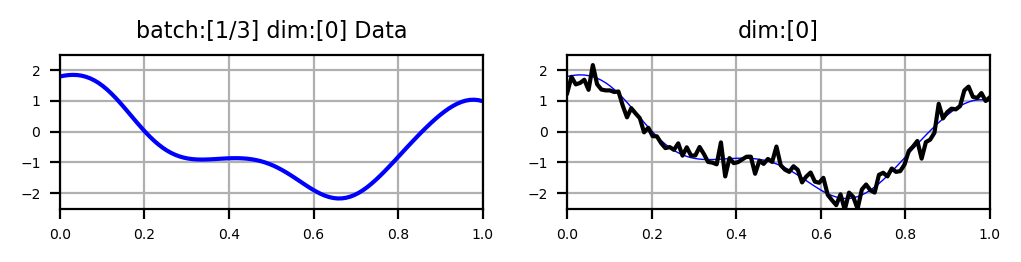

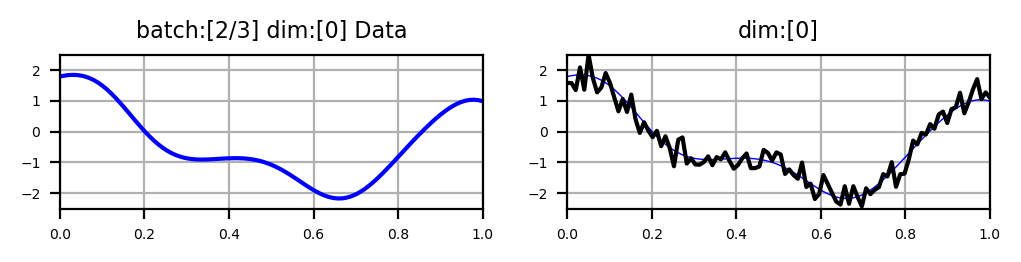

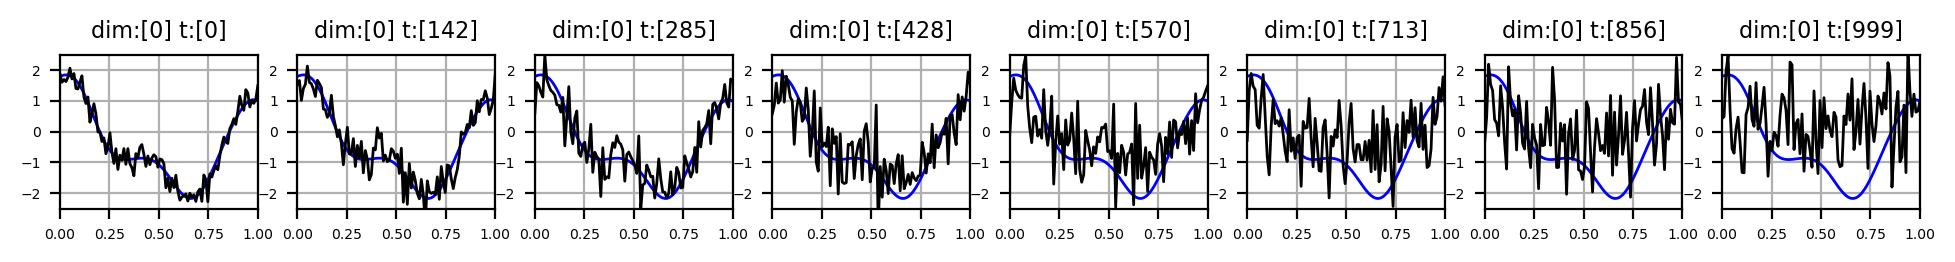

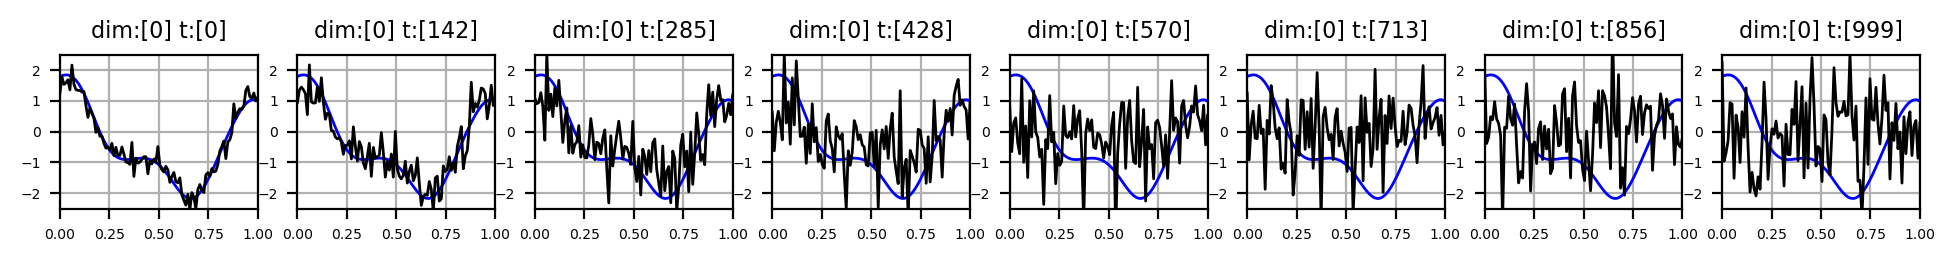

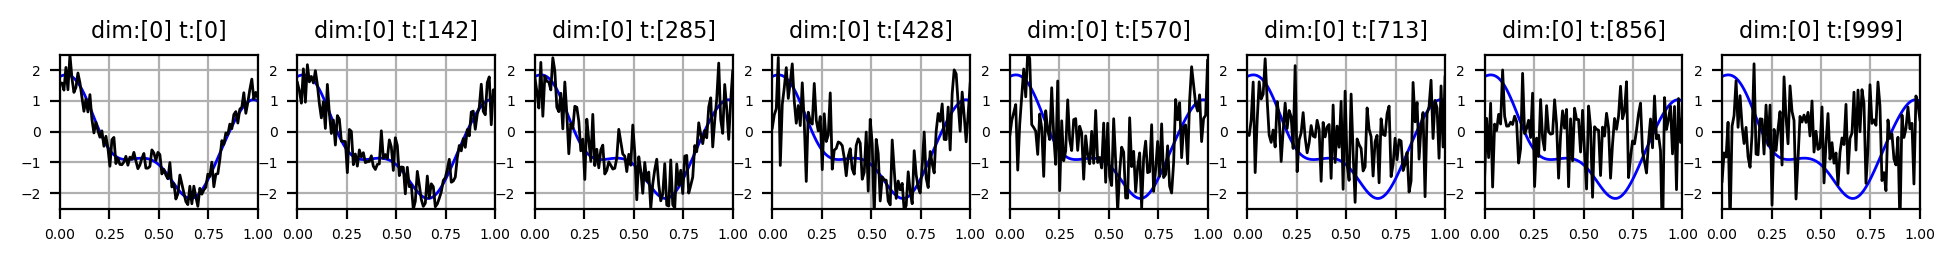

Done.


In [6]:
# Set Hilbert forward process
K_chols_np = np.zeros(shape=(D,L,L)) # [D x L x L]
for d_idx in range(D):
    K = np.eye(L,L) # [L x L]
    K_chols_np[d_idx,:,:] = np.linalg.cholesky(K+1e-8*np.eye(L,L)) # [L x L]
K_chols = np2torch(K_chols_np,device=device) # [D x L x L]
# Set RHKS projections
RKHS_projs = None
# Model
model = DenoisingDenseUNetClass(
    D=D,L=L,pos_emb_dim=32,h_dims=[128,64,32],z_dim=32,
    actv=actv,USE_POS_EMB=True,RKHS_projs=RKHS_projs)
model.to(device)
# Train
model.train()
optm = torch.optim.Adam(
    model.parameters(),lr=base_lr,betas=(0.9, 0.999),eps=1e-03,weight_decay=1e-08)
lr_schd = torch.optim.lr_scheduler.StepLR(optm,step_size=int(0.4*MAX_ITER),gamma=0.5)
for it in range(MAX_ITER):
    optm.zero_grad()
    t = torch.randint(0, dc['T'],(BATCH_SIZE,),device=device).long() # [B]
    loss = get_ddpm_loss(
        model=model,x_0=x_batch,K_chols=K_chols,t=t,dc=dc,noise_rate=1.0,
        RKHS_projs=RKHS_projs,noise_type='Gaussian',
        l1_w=l1_w,l2_w=l2_w,huber_w=huber_w,smt_l1_w=huber_w)
    loss.backward(); optm.step(); lr_schd.step()
    if ((it % (MAX_ITER//20)) == 0) or (it==(MAX_ITER-1)):
        print ("[%d/%d][%.2f%%] loss:[%.3f]"%(it,MAX_ITER,100*it/MAX_ITER,loss.item()))
    if ((it % (MAX_ITER//5)) == 0) or (it==(MAX_ITER-1)):
        eval_hddpm_1D(
            model,dc,K_chols,RKHS_projs,times,x_0,
            B=3,M=8,device=device,
            RKHS_PROJECTION_EACH_X_T=False)
print ("Done.")